In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 16, 100, 100))

In [12]:
image = 1-image/100

In [13]:
image.shape

(133, 16, 100, 100)

In [14]:
image[0,0,:,:]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

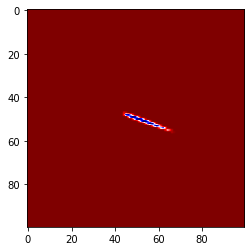

In [15]:
aaa=plt.imshow(image[0,15,:,:].T, cmap='seismic')
aaa.colorbar

In [16]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [17]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [18]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [19]:
y = y.reshape((133, 16, 2, 1))

In [20]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [21]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [22]:
geometry.shape

(2128, 1)

In [23]:
geometry = geometry.reshape((133, 16, 1))

In [24]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [25]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [26]:
x_train.shape

(2016, 100, 100, 1)

In [27]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 50)      1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 50)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 125000)            0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               25000200  
                                                                 
 secondHiddenLayer (Dense)   (None, 100)               20100     
                                                             

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 3s 8ms/step - loss: 3.2240 - rmse: 1.7955
Epoch 2/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0865 - rmse: 0.2941
Epoch 3/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0238 - rmse: 0.1543
Epoch 4/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0337 - rmse: 0.1836
Epoch 5/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0197 - rmse: 0.1402
Epoch 6/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0329 - rmse: 0.1813
Epoch 7/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1164
Epoch 8/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 9/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0121 - rmse: 0.1099
Epoch 10/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0211 - rmse: 0.1451
Epoch 11/5000
63/63 [==================

63/63 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0779
Epoch 86/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0736
Epoch 87/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0050 - rmse: 0.0706
Epoch 88/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0052 - rmse: 0.0720
Epoch 89/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0049 - rmse: 0.0703
Epoch 90/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 91/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0048 - rmse: 0.0694
Epoch 92/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0050 - rmse: 0.0710
Epoch 93/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0048 - rmse: 0.0692
Epoch 94/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0048 - rmse: 0.0692
Epoch 95/5000
63/63 [=======================

63/63 [==============================] - 0s 7ms/step - loss: 0.0038 - rmse: 0.0618
Epoch 169/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0038 - rmse: 0.0616
Epoch 170/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0592
Epoch 171/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0593
Epoch 172/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0587
Epoch 173/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0602
Epoch 174/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0603
Epoch 175/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0602
Epoch 176/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0034 - rmse: 0.0582
Epoch 177/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0603
Epoch 178/5000
63/63 [=============

63/63 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0508
Epoch 252/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0515
Epoch 253/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0031 - rmse: 0.0560
Epoch 254/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0525
Epoch 255/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0517
Epoch 256/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0513
Epoch 257/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0523
Epoch 258/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0510
Epoch 259/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0501
Epoch 260/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0504
Epoch 261/5000
63/63 [=============

63/63 [==============================] - 0s 8ms/step - loss: 0.0021 - rmse: 0.0462
Epoch 335/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0450
Epoch 336/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0457
Epoch 337/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0445
Epoch 338/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0433
Epoch 339/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 340/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0437
Epoch 341/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0449
Epoch 342/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0469
Epoch 343/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 344/5000
63/63 [=============

63/63 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0390
Epoch 418/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0383
Epoch 419/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0378
Epoch 420/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0380
Epoch 421/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 422/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 423/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0390
Epoch 424/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0395
Epoch 425/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0383
Epoch 426/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0413
Epoch 427/5000
63/63 [=============

63/63 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 501/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0339
Epoch 502/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 503/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 504/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0372
Epoch 505/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0394
Epoch 506/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0339
Epoch 507/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0338
Epoch 508/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0333
Epoch 509/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0330
Epoch 510/5000
63/63 [=============

63/63 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0349
Epoch 583/5000
63/63 [==============================] - 0s 7ms/step - loss: 8.4938e-04 - rmse: 0.0291
Epoch 584/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.7455e-04 - rmse: 0.0278
Epoch 585/5000
63/63 [==============================] - 0s 7ms/step - loss: 8.4198e-04 - rmse: 0.0290
Epoch 586/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.7717e-04 - rmse: 0.0278
Epoch 587/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 588/5000
63/63 [==============================] - 0s 7ms/step - loss: 8.7227e-04 - rmse: 0.0295
Epoch 589/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.8324e-04 - rmse: 0.0280
Epoch 590/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.1151e-04 - rmse: 0.0266
Epoch 591/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.6614e-04 - rmse: 0.0276
Epo

63/63 [==============================] - 0s 7ms/step - loss: 8.0480e-04 - rmse: 0.0283
Epoch 663/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.9635e-04 - rmse: 0.0264
Epoch 664/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.4357e-04 - rmse: 0.0253
Epoch 665/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.4448e-04 - rmse: 0.0254
Epoch 666/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.5022e-04 - rmse: 0.0255
Epoch 667/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.2572e-04 - rmse: 0.0269
Epoch 668/5000
63/63 [==============================] - 0s 7ms/step - loss: 8.7224e-04 - rmse: 0.0295
Epoch 669/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.6478e-04 - rmse: 0.0257
Epoch 670/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.5588e-04 - rmse: 0.0256
Epoch 671/5000
63/63 [==============================] - 0s 7ms/step - loss: 8.0754e-04 - rmse: 0.

63/63 [==============================] - 0s 7ms/step - loss: 9.3278e-04 - rmse: 0.0305
Epoch 743/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 744/5000
63/63 [==============================] - 0s 7ms/step - loss: 8.1662e-04 - rmse: 0.0285
Epoch 745/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.3978e-04 - rmse: 0.0253
Epoch 746/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.7263e-04 - rmse: 0.0278
Epoch 747/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.8039e-04 - rmse: 0.0261
Epoch 748/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.3878e-04 - rmse: 0.0271
Epoch 749/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.1581e-04 - rmse: 0.0248
Epoch 750/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.0847e-04 - rmse: 0.0246
Epoch 751/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.1801e-04 - rmse: 0.0248

63/63 [==============================] - 0s 7ms/step - loss: 6.2735e-04 - rmse: 0.0250
Epoch 823/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.6762e-04 - rmse: 0.0258
Epoch 824/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.2345e-04 - rmse: 0.0269
Epoch 825/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.1454e-04 - rmse: 0.0248
Epoch 826/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.5395e-04 - rmse: 0.0235
Epoch 827/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.1880e-04 - rmse: 0.0227
Epoch 828/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.0378e-04 - rmse: 0.0245
Epoch 829/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.3989e-04 - rmse: 0.0232
Epoch 830/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.9512e-04 - rmse: 0.0244
Epoch 831/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.2772e-04 - rmse: 0.

63/63 [==============================] - 0s 7ms/step - loss: 4.9883e-04 - rmse: 0.0223
Epoch 903/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.7623e-04 - rmse: 0.0240
Epoch 904/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.5376e-04 - rmse: 0.0235
Epoch 905/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.0745e-04 - rmse: 0.0246
Epoch 906/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.3892e-04 - rmse: 0.0232
Epoch 907/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.8523e-04 - rmse: 0.0242
Epoch 908/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.6328e-04 - rmse: 0.0237
Epoch 909/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.9211e-04 - rmse: 0.0221
Epoch 910/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.4331e-04 - rmse: 0.0233
Epoch 911/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.5573e-04 - rmse: 0.

63/63 [==============================] - 0s 7ms/step - loss: 4.5587e-04 - rmse: 0.0213
Epoch 983/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.0088e-04 - rmse: 0.0223
Epoch 984/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.2254e-04 - rmse: 0.0228
Epoch 985/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.3717e-04 - rmse: 0.0252
Epoch 986/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.1502e-04 - rmse: 0.0248
Epoch 987/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.9965e-04 - rmse: 0.0223
Epoch 988/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.3098e-04 - rmse: 0.0230
Epoch 989/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.6060e-04 - rmse: 0.0214
Epoch 990/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.7661e-04 - rmse: 0.0218
Epoch 991/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.1710e-04 - rmse: 0.

63/63 [==============================] - 0s 7ms/step - loss: 4.5784e-04 - rmse: 0.0214
Epoch 1062/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.8840e-04 - rmse: 0.0242
Epoch 1063/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.5240e-04 - rmse: 0.0235
Epoch 1064/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.0220e-04 - rmse: 0.0224
Epoch 1065/5000
63/63 [==============================] - 0s 8ms/step - loss: 4.3744e-04 - rmse: 0.0209
Epoch 1066/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.6386e-04 - rmse: 0.0215
Epoch 1067/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.6533e-04 - rmse: 0.0215
Epoch 1068/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.7707e-04 - rmse: 0.0218
Epoch 1069/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.7265e-04 - rmse: 0.0217
Epoch 1070/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.8087e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 5.1178e-04 - rmse: 0.0226
Epoch 1141/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.0062e-04 - rmse: 0.0223
Epoch 1142/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.0242e-04 - rmse: 0.0224
Epoch 1143/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5628e-04 - rmse: 0.0213
Epoch 1144/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.7084e-04 - rmse: 0.0217
Epoch 1145/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4907e-04 - rmse: 0.0211
Epoch 1146/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.3117e-04 - rmse: 0.0207
Epoch 1147/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.3812e-04 - rmse: 0.0209
Epoch 1148/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.1759e-04 - rmse: 0.0227
Epoch 1149/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4100e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 4.9694e-04 - rmse: 0.0223
Epoch 1220/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.2582e-04 - rmse: 0.0206
Epoch 1221/5000
63/63 [==============================] - 0s 7ms/step - loss: 6.3381e-04 - rmse: 0.0251
Epoch 1222/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.8800e-04 - rmse: 0.0242
Epoch 1223/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.1309e-04 - rmse: 0.0226
Epoch 1224/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.2252e-04 - rmse: 0.0205
Epoch 1225/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5646e-04 - rmse: 0.0213
Epoch 1226/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5201e-04 - rmse: 0.0212
Epoch 1227/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.6527e-04 - rmse: 0.0191
Epoch 1228/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.1732e-04 -

63/63 [==============================] - 0s 8ms/step - loss: 4.5346e-04 - rmse: 0.0213
Epoch 1299/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4764e-04 - rmse: 0.0211
Epoch 1300/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4067e-04 - rmse: 0.0209
Epoch 1301/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5664e-04 - rmse: 0.0213
Epoch 1302/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.0552e-04 - rmse: 0.0201
Epoch 1303/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.8515e-04 - rmse: 0.0196
Epoch 1304/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.8144e-04 - rmse: 0.0195
Epoch 1305/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.3767e-04 - rmse: 0.0209
Epoch 1306/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5537e-04 - rmse: 0.0213
Epoch 1307/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.9630e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 4.7891e-04 - rmse: 0.0218
Epoch 1378/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4958e-04 - rmse: 0.0212
Epoch 1379/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.9369e-04 - rmse: 0.0198
Epoch 1380/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.2067e-04 - rmse: 0.0205
Epoch 1381/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.6207e-04 - rmse: 0.0190
Epoch 1382/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.9329e-04 - rmse: 0.0198
Epoch 1383/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.6707e-04 - rmse: 0.0216
Epoch 1384/5000
63/63 [==============================] - 0s 8ms/step - loss: 4.7546e-04 - rmse: 0.0218
Epoch 1385/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.1027e-04 - rmse: 0.0202
Epoch 1386/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.1969e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 4.0670e-04 - rmse: 0.0201
Epoch 1457/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.7910e-04 - rmse: 0.0218
Epoch 1458/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5779e-04 - rmse: 0.0214
Epoch 1459/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7537e-04 - rmse: 0.0193
Epoch 1460/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7236e-04 - rmse: 0.0192
Epoch 1461/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.9093e-04 - rmse: 0.0197
Epoch 1462/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5975e-04 - rmse: 0.0189
Epoch 1463/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4878e-04 - rmse: 0.0186
Epoch 1464/5000
63/63 [==============================] - 0s 8ms/step - loss: 4.0174e-04 - rmse: 0.0200
Epoch 1465/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3550e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.6582e-04 - rmse: 0.0191
Epoch 1536/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7559e-04 - rmse: 0.0193
Epoch 1537/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.3401e-04 - rmse: 0.0182
Epoch 1538/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.8185e-04 - rmse: 0.0195
Epoch 1539/5000
63/63 [==============================] - 0s 8ms/step - loss: 4.3972e-04 - rmse: 0.0209
Epoch 1540/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.1868e-04 - rmse: 0.0204
Epoch 1541/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.6621e-04 - rmse: 0.0215
Epoch 1542/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.0236e-04 - rmse: 0.0200
Epoch 1543/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.9008e-04 - rmse: 0.0197
Epoch 1544/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.1845e-04 -

63/63 [==============================] - 0s 8ms/step - loss: 4.1047e-04 - rmse: 0.0202
Epoch 1615/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.2976e-04 - rmse: 0.0230
Epoch 1616/5000
63/63 [==============================] - 0s 8ms/step - loss: 9.4047e-04 - rmse: 0.0306
Epoch 1617/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0418
Epoch 1618/5000
63/63 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0381
Epoch 1619/5000
63/63 [==============================] - 0s 8ms/step - loss: 5.5186e-04 - rmse: 0.0234
Epoch 1620/5000
63/63 [==============================] - 0s 8ms/step - loss: 4.3313e-04 - rmse: 0.0208
Epoch 1621/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.5289e-04 - rmse: 0.0187
Epoch 1622/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0713e-04 - rmse: 0.0175
Epoch 1623/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8827e-04 - rmse: 0

63/63 [==============================] - 0s 7ms/step - loss: 3.7684e-04 - rmse: 0.0194
Epoch 1694/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.3635e-04 - rmse: 0.0183
Epoch 1695/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.6027e-04 - rmse: 0.0189
Epoch 1696/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5963e-04 - rmse: 0.0214
Epoch 1697/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7642e-04 - rmse: 0.0193
Epoch 1698/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.3179e-04 - rmse: 0.0182
Epoch 1699/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.6283e-04 - rmse: 0.0190
Epoch 1700/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4074e-04 - rmse: 0.0184
Epoch 1701/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3575e-04 - rmse: 0.0183
Epoch 1702/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.6573e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.5165e-04 - rmse: 0.0158
Epoch 1773/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0288e-04 - rmse: 0.0173
Epoch 1774/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0285e-04 - rmse: 0.0173
Epoch 1775/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8808e-04 - rmse: 0.0169
Epoch 1776/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7608e-04 - rmse: 0.0166
Epoch 1777/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1736e-04 - rmse: 0.0178
Epoch 1778/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1573e-04 - rmse: 0.0177
Epoch 1779/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1655e-04 - rmse: 0.0177
Epoch 1780/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.0780e-04 - rmse: 0.0201
Epoch 1781/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.8753e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.4371e-04 - rmse: 0.0185
Epoch 1852/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.3000e-04 - rmse: 0.0207
Epoch 1853/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4800e-04 - rmse: 0.0211
Epoch 1854/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3029e-04 - rmse: 0.0181
Epoch 1855/5000
63/63 [==============================] - 0s 8ms/step - loss: 4.1781e-04 - rmse: 0.0204
Epoch 1856/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4231e-04 - rmse: 0.0184
Epoch 1857/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0587e-04 - rmse: 0.0174
Epoch 1858/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6464e-04 - rmse: 0.0162
Epoch 1859/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.9781e-04 - rmse: 0.0172
Epoch 1860/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6492e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.2398e-04 - rmse: 0.0179
Epoch 1931/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7715e-04 - rmse: 0.0194
Epoch 1932/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1271e-04 - rmse: 0.0176
Epoch 1933/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8981e-04 - rmse: 0.0170
Epoch 1934/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0479e-04 - rmse: 0.0174
Epoch 1935/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4869e-04 - rmse: 0.0186
Epoch 1936/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6948e-04 - rmse: 0.0163
Epoch 1937/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3615e-04 - rmse: 0.0183
Epoch 1938/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4993e-04 - rmse: 0.0186
Epoch 1939/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5744e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.2275e-04 - rmse: 0.0179
Epoch 2010/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4007e-04 - rmse: 0.0184
Epoch 2011/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.6625e-04 - rmse: 0.0191
Epoch 2012/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.2524e-04 - rmse: 0.0180
Epoch 2013/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5579e-04 - rmse: 0.0188
Epoch 2014/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7334e-04 - rmse: 0.0193
Epoch 2015/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5664e-04 - rmse: 0.0188
Epoch 2016/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.8224e-04 - rmse: 0.0167
Epoch 2017/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1677e-04 - rmse: 0.0177
Epoch 2018/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4813e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.0709e-04 - rmse: 0.0175
Epoch 2089/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9089e-04 - rmse: 0.0170
Epoch 2090/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8278e-04 - rmse: 0.0167
Epoch 2091/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7980e-04 - rmse: 0.0167
Epoch 2092/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5573e-04 - rmse: 0.0159
Epoch 2093/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0043e-04 - rmse: 0.0173
Epoch 2094/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1606e-04 - rmse: 0.0177
Epoch 2095/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0603e-04 - rmse: 0.0174
Epoch 2096/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5705e-04 - rmse: 0.0160
Epoch 2097/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0385e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.7369e-04 - rmse: 0.0165
Epoch 2168/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6081e-04 - rmse: 0.0161
Epoch 2169/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.2365e-04 - rmse: 0.0179
Epoch 2170/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3456e-04 - rmse: 0.0182
Epoch 2171/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.2297e-04 - rmse: 0.0205
Epoch 2172/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7142e-04 - rmse: 0.0192
Epoch 2173/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.2806e-04 - rmse: 0.0180
Epoch 2174/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3482e-04 - rmse: 0.0182
Epoch 2175/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0381e-04 - rmse: 0.0174
Epoch 2176/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.2618e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 4.5015e-04 - rmse: 0.0212
Epoch 2247/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4613e-04 - rmse: 0.0185
Epoch 2248/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6007e-04 - rmse: 0.0161
Epoch 2249/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5920e-04 - rmse: 0.0160
Epoch 2250/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9087e-04 - rmse: 0.0170
Epoch 2251/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3871e-04 - rmse: 0.0154
Epoch 2252/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5250e-04 - rmse: 0.0158
Epoch 2253/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8572e-04 - rmse: 0.0168
Epoch 2254/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1077e-04 - rmse: 0.0176
Epoch 2255/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1277e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.0176e-04 - rmse: 0.0173
Epoch 2326/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7033e-04 - rmse: 0.0164
Epoch 2327/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.2612e-04 - rmse: 0.0180
Epoch 2328/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9962e-04 - rmse: 0.0172
Epoch 2329/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1416e-04 - rmse: 0.0177
Epoch 2330/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.0858e-04 - rmse: 0.0175
Epoch 2331/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4981e-04 - rmse: 0.0186
Epoch 2332/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8129e-04 - rmse: 0.0167
Epoch 2333/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9854e-04 - rmse: 0.0172
Epoch 2334/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0465e-04 -

63/63 [==============================] - 0s 8ms/step - loss: 3.4934e-04 - rmse: 0.0186
Epoch 2405/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.6696e-04 - rmse: 0.0163
Epoch 2406/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.3380e-04 - rmse: 0.0152
Epoch 2407/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.3801e-04 - rmse: 0.0153
Epoch 2408/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.2591e-04 - rmse: 0.0149
Epoch 2409/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.4262e-04 - rmse: 0.0155
Epoch 2410/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.7315e-04 - rmse: 0.0165
Epoch 2411/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.4871e-04 - rmse: 0.0157
Epoch 2412/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.6651e-04 - rmse: 0.0162
Epoch 2413/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.2094e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.8179e-04 - rmse: 0.0167
Epoch 2484/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7529e-04 - rmse: 0.0165
Epoch 2485/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8572e-04 - rmse: 0.0168
Epoch 2486/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5226e-04 - rmse: 0.0158
Epoch 2487/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8810e-04 - rmse: 0.0169
Epoch 2488/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.3043e-04 - rmse: 0.0207
Epoch 2489/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4806e-04 - rmse: 0.0186
Epoch 2490/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.7864e-04 - rmse: 0.0218
Epoch 2491/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3209e-04 - rmse: 0.0182
Epoch 2492/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8246e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.3290e-04 - rmse: 0.0152
Epoch 2563/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4442e-04 - rmse: 0.0156
Epoch 2564/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1654e-04 - rmse: 0.0146
Epoch 2565/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4796e-04 - rmse: 0.0157
Epoch 2566/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7709e-04 - rmse: 0.0166
Epoch 2567/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4382e-04 - rmse: 0.0155
Epoch 2568/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5937e-04 - rmse: 0.0160
Epoch 2569/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8895e-04 - rmse: 0.0169
Epoch 2570/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4503e-04 - rmse: 0.0185
Epoch 2571/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5624e-04 -

63/63 [==============================] - 0s 8ms/step - loss: 3.0266e-04 - rmse: 0.0173
Epoch 2642/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.3710e-04 - rmse: 0.0153
Epoch 2643/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.8047e-04 - rmse: 0.0167
Epoch 2644/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.5948e-04 - rmse: 0.0189
Epoch 2645/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.0497e-04 - rmse: 0.0174
Epoch 2646/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.3518e-04 - rmse: 0.0153
Epoch 2647/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.8207e-04 - rmse: 0.0167
Epoch 2648/5000
63/63 [==============================] - 0s 8ms/step - loss: 3.2202e-04 - rmse: 0.0179
Epoch 2649/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.4493e-04 - rmse: 0.0156
Epoch 2650/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.8471e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.1339e-04 - rmse: 0.0176
Epoch 2721/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0907e-04 - rmse: 0.0175
Epoch 2722/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4391e-04 - rmse: 0.0185
Epoch 2723/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4026e-04 - rmse: 0.0184
Epoch 2724/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6912e-04 - rmse: 0.0163
Epoch 2725/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2533e-04 - rmse: 0.0149
Epoch 2726/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8818e-04 - rmse: 0.0169
Epoch 2727/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5323e-04 - rmse: 0.0158
Epoch 2728/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5919e-04 - rmse: 0.0160
Epoch 2729/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6980e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.9906e-04 - rmse: 0.0140
Epoch 2800/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1486e-04 - rmse: 0.0146
Epoch 2801/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2165e-04 - rmse: 0.0148
Epoch 2802/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1780e-04 - rmse: 0.0147
Epoch 2803/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1136e-04 - rmse: 0.0144
Epoch 2804/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.0934e-04 - rmse: 0.0144
Epoch 2805/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2077e-04 - rmse: 0.0148
Epoch 2806/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4683e-04 - rmse: 0.0156
Epoch 2807/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2558e-04 - rmse: 0.0149
Epoch 2808/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5066e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.1725e-04 - rmse: 0.0146
Epoch 2879/5000
63/63 [==============================] - 0s 8ms/step - loss: 2.1191e-04 - rmse: 0.0145
Epoch 2880/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1002e-04 - rmse: 0.0144
Epoch 2881/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7832e-04 - rmse: 0.0166
Epoch 2882/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4783e-04 - rmse: 0.0157
Epoch 2883/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9023e-04 - rmse: 0.0170
Epoch 2884/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8019e-04 - rmse: 0.0167
Epoch 2885/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1641e-04 - rmse: 0.0177
Epoch 2886/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.2638e-04 - rmse: 0.0180
Epoch 2887/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3306e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.2943e-04 - rmse: 0.0151
Epoch 2958/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.0418e-04 - rmse: 0.0142
Epoch 2959/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8103e-04 - rmse: 0.0167
Epoch 2960/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0024e-04 - rmse: 0.0172
Epoch 2961/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0181e-04 - rmse: 0.0173
Epoch 2962/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0612e-04 - rmse: 0.0174
Epoch 2963/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3234e-04 - rmse: 0.0152
Epoch 2964/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5575e-04 - rmse: 0.0159
Epoch 2965/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4122e-04 - rmse: 0.0154
Epoch 2966/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3160e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.9418e-04 - rmse: 0.0138
Epoch 3037/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.7677e-04 - rmse: 0.0132
Epoch 3038/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1995e-04 - rmse: 0.0147
Epoch 3039/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1604e-04 - rmse: 0.0146
Epoch 3040/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1260e-04 - rmse: 0.0145
Epoch 3041/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1857e-04 - rmse: 0.0147
Epoch 3042/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5367e-04 - rmse: 0.0158
Epoch 3043/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9334e-04 - rmse: 0.0138
Epoch 3044/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9412e-04 - rmse: 0.0171
Epoch 3045/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3955e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.8899e-04 - rmse: 0.0136
Epoch 3116/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.0352e-04 - rmse: 0.0142
Epoch 3117/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3795e-04 - rmse: 0.0153
Epoch 3118/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2694e-04 - rmse: 0.0150
Epoch 3119/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3532e-04 - rmse: 0.0152
Epoch 3120/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9110e-04 - rmse: 0.0137
Epoch 3121/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6248e-04 - rmse: 0.0126
Epoch 3122/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9672e-04 - rmse: 0.0139
Epoch 3123/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9927e-04 - rmse: 0.0172
Epoch 3124/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3538e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.1110e-04 - rmse: 0.0144
Epoch 3195/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3551e-04 - rmse: 0.0182
Epoch 3196/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.9017e-04 - rmse: 0.0197
Epoch 3197/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5976e-04 - rmse: 0.0214
Epoch 3198/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.4142e-04 - rmse: 0.0184
Epoch 3199/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8108e-04 - rmse: 0.0167
Epoch 3200/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9166e-04 - rmse: 0.0170
Epoch 3201/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3082e-04 - rmse: 0.0151
Epoch 3202/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.0524e-04 - rmse: 0.0142
Epoch 3203/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1407e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.8667e-04 - rmse: 0.0136
Epoch 3274/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1285e-04 - rmse: 0.0176
Epoch 3275/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3886e-04 - rmse: 0.0154
Epoch 3276/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2380e-04 - rmse: 0.0149
Epoch 3277/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9561e-04 - rmse: 0.0139
Epoch 3278/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0218e-04 - rmse: 0.0173
Epoch 3279/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5622e-04 - rmse: 0.0159
Epoch 3280/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9061e-04 - rmse: 0.0137
Epoch 3281/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4048e-04 - rmse: 0.0154
Epoch 3282/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6303e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 2.6049e-04 - rmse: 0.0160
Epoch 3353/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6063e-04 - rmse: 0.0126
Epoch 3354/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5383e-04 - rmse: 0.0123
Epoch 3355/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5954e-04 - rmse: 0.0125
Epoch 3356/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5063e-04 - rmse: 0.0121
Epoch 3357/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9667e-04 - rmse: 0.0139
Epoch 3358/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6853e-04 - rmse: 0.0129
Epoch 3359/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.9429e-04 - rmse: 0.0138
Epoch 3360/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5064e-04 - rmse: 0.0121
Epoch 3361/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6044e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.6901e-04 - rmse: 0.0191
Epoch 3432/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.7760e-04 - rmse: 0.0194
Epoch 3433/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3335e-04 - rmse: 0.0152
Epoch 3434/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4265e-04 - rmse: 0.0155
Epoch 3435/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5864e-04 - rmse: 0.0125
Epoch 3436/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3703e-04 - rmse: 0.0116
Epoch 3437/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.8823e-04 - rmse: 0.0136
Epoch 3438/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.8360e-04 - rmse: 0.0134
Epoch 3439/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6220e-04 - rmse: 0.0126
Epoch 3440/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4763e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.5771e-04 - rmse: 0.0124
Epoch 3511/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2969e-04 - rmse: 0.0113
Epoch 3512/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3821e-04 - rmse: 0.0116
Epoch 3513/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4100e-04 - rmse: 0.0117
Epoch 3514/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6166e-04 - rmse: 0.0126
Epoch 3515/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3152e-04 - rmse: 0.0113
Epoch 3516/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1812e-04 - rmse: 0.0107
Epoch 3517/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1286e-04 - rmse: 0.0105
Epoch 3518/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0717e-04 - rmse: 0.0102
Epoch 3519/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4260e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.2705e-04 - rmse: 0.0111
Epoch 3590/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5233e-04 - rmse: 0.0122
Epoch 3591/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.7569e-04 - rmse: 0.0131
Epoch 3592/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.8269e-04 - rmse: 0.0134
Epoch 3593/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7694e-04 - rmse: 0.0165
Epoch 3594/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4411e-04 - rmse: 0.0210
Epoch 3595/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.2062e-04 - rmse: 0.0268
Epoch 3596/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 3597/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.5488e-04 - rmse: 0.0213
Epoch 3598/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4016e-04 - rms

63/63 [==============================] - 0s 7ms/step - loss: 4.7243e-04 - rmse: 0.0217
Epoch 3669/5000
63/63 [==============================] - 0s 7ms/step - loss: 7.9176e-04 - rmse: 0.0281
Epoch 3670/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0320
Epoch 3671/5000
63/63 [==============================] - 0s 7ms/step - loss: 9.9189e-04 - rmse: 0.0314
Epoch 3672/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 3673/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.8056e-04 - rmse: 0.0218
Epoch 3674/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6401e-04 - rmse: 0.0161
Epoch 3675/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.8983e-04 - rmse: 0.0137
Epoch 3676/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4280e-04 - rmse: 0.0118
Epoch 3677/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3313e-04 - rmse: 0

63/63 [==============================] - 0s 7ms/step - loss: 4.6708e-04 - rmse: 0.0215
Epoch 3748/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.1714e-04 - rmse: 0.0227
Epoch 3749/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.6141e-04 - rmse: 0.0189
Epoch 3750/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2657e-04 - rmse: 0.0149
Epoch 3751/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.8443e-04 - rmse: 0.0135
Epoch 3752/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.5442e-04 - rmse: 0.0123
Epoch 3753/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3401e-04 - rmse: 0.0114
Epoch 3754/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3183e-04 - rmse: 0.0113
Epoch 3755/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3010e-04 - rmse: 0.0113
Epoch 3756/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2033e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.1072e-04 - rmse: 0.0104
Epoch 3827/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3229e-04 - rmse: 0.0114
Epoch 3828/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2215e-04 - rmse: 0.0109
Epoch 3829/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3107e-04 - rmse: 0.0113
Epoch 3830/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3885e-04 - rmse: 0.0116
Epoch 3831/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2966e-04 - rmse: 0.0112
Epoch 3832/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4822e-04 - rmse: 0.0120
Epoch 3833/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4139e-04 - rmse: 0.0118
Epoch 3834/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6638e-04 - rmse: 0.0162
Epoch 3835/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1235e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.3188e-04 - rmse: 0.0113
Epoch 3906/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3233e-04 - rmse: 0.0114
Epoch 3907/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4020e-04 - rmse: 0.0117
Epoch 3908/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5968e-04 - rmse: 0.0125
Epoch 3909/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3405e-04 - rmse: 0.0114
Epoch 3910/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5714e-04 - rmse: 0.0124
Epoch 3911/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5804e-04 - rmse: 0.0160
Epoch 3912/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0446
Epoch 3913/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0425
Epoch 3914/5000
63/63 [==============================] - 0s 7ms/step - loss: 9.6177e-04 - rmse: 0

63/63 [==============================] - 0s 7ms/step - loss: 1.0806e-04 - rmse: 0.0102
Epoch 3985/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0623e-04 - rmse: 0.0101
Epoch 3986/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0731e-04 - rmse: 0.0102
Epoch 3987/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1054e-04 - rmse: 0.0104
Epoch 3988/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2929e-04 - rmse: 0.0112
Epoch 3989/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2418e-04 - rmse: 0.0110
Epoch 3990/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1534e-04 - rmse: 0.0106
Epoch 3991/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4104e-04 - rmse: 0.0117
Epoch 3992/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2730e-04 - rmse: 0.0111
Epoch 3993/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2553e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.1998e-04 - rmse: 0.0108
Epoch 4064/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1314e-04 - rmse: 0.0105
Epoch 4065/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1202e-04 - rmse: 0.0104
Epoch 4066/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1828e-04 - rmse: 0.0107
Epoch 4067/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2028e-04 - rmse: 0.0108
Epoch 4068/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2322e-04 - rmse: 0.0109
Epoch 4069/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2478e-04 - rmse: 0.0110
Epoch 4070/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5008e-04 - rmse: 0.0121
Epoch 4071/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1288e-04 - rmse: 0.0145
Epoch 4072/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6230e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.3439e-04 - rmse: 0.0114
Epoch 4143/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2537e-04 - rmse: 0.0110
Epoch 4144/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1332e-04 - rmse: 0.0105
Epoch 4145/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0374e-04 - rmse: 0.0100
Epoch 4146/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0030e-04 - rmse: 0.0098
Epoch 4147/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0130e-04 - rmse: 0.0099
Epoch 4148/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1329e-04 - rmse: 0.0105
Epoch 4149/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2049e-04 - rmse: 0.0108
Epoch 4150/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1866e-04 - rmse: 0.0107
Epoch 4151/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2498e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.5931e-04 - rmse: 0.0125
Epoch 4222/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5568e-04 - rmse: 0.0159
Epoch 4223/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1812e-04 - rmse: 0.0147
Epoch 4224/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2967e-04 - rmse: 0.0112
Epoch 4225/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2814e-04 - rmse: 0.0112
Epoch 4226/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5290e-04 - rmse: 0.0122
Epoch 4227/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4705e-04 - rmse: 0.0120
Epoch 4228/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1446e-04 - rmse: 0.0105
Epoch 4229/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2194e-04 - rmse: 0.0109
Epoch 4230/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1290e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 4.0145e-04 - rmse: 0.0199
Epoch 4301/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5864e-04 - rmse: 0.0188
Epoch 4302/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.4031e-04 - rmse: 0.0209
Epoch 4303/5000
63/63 [==============================] - 0s 7ms/step - loss: 4.2668e-04 - rmse: 0.0206
Epoch 4304/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.2167e-04 - rmse: 0.0148
Epoch 4305/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5840e-04 - rmse: 0.0124
Epoch 4306/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1551e-04 - rmse: 0.0106
Epoch 4307/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0998e-04 - rmse: 0.0103
Epoch 4308/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1509e-04 - rmse: 0.0106
Epoch 4309/5000
63/63 [==============================] - 0s 7ms/step - loss: 9.9704e-05 -

63/63 [==============================] - 0s 7ms/step - loss: 1.1252e-04 - rmse: 0.0104
Epoch 4380/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0929e-04 - rmse: 0.0103
Epoch 4381/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0610e-04 - rmse: 0.0101
Epoch 4382/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1298e-04 - rmse: 0.0105
Epoch 4383/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0578e-04 - rmse: 0.0101
Epoch 4384/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0833e-04 - rmse: 0.0102
Epoch 4385/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0552e-04 - rmse: 0.0101
Epoch 4386/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2284e-04 - rmse: 0.0109
Epoch 4387/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1555e-04 - rmse: 0.0106
Epoch 4388/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1756e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 6.3117e-04 - rmse: 0.0251
Epoch 4459/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7791e-04 - rmse: 0.0166
Epoch 4460/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.1104e-04 - rmse: 0.0144
Epoch 4461/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5745e-04 - rmse: 0.0124
Epoch 4462/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.3946e-04 - rmse: 0.0117
Epoch 4463/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2370e-04 - rmse: 0.0110
Epoch 4464/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2164e-04 - rmse: 0.0109
Epoch 4465/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2024e-04 - rmse: 0.0108
Epoch 4466/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4539e-04 - rmse: 0.0119
Epoch 4467/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.3650e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 3.8300e-04 - rmse: 0.0195
Epoch 4538/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.5634e-04 - rmse: 0.0188
Epoch 4539/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.0585e-04 - rmse: 0.0174
Epoch 4540/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.3463e-04 - rmse: 0.0152
Epoch 4541/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5628e-04 - rmse: 0.0159
Epoch 4542/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.5539e-04 - rmse: 0.0159
Epoch 4543/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.6013e-04 - rmse: 0.0160
Epoch 4544/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8930e-04 - rmse: 0.0169
Epoch 4545/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6313e-04 - rmse: 0.0126
Epoch 4546/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1820e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.1699e-04 - rmse: 0.0106
Epoch 4617/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1582e-04 - rmse: 0.0106
Epoch 4618/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2200e-04 - rmse: 0.0109
Epoch 4619/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5169e-04 - rmse: 0.0122
Epoch 4620/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.3444e-04 - rmse: 0.0182
Epoch 4621/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.8149e-04 - rmse: 0.0167
Epoch 4622/5000
63/63 [==============================] - 0s 7ms/step - loss: 3.1976e-04 - rmse: 0.0178
Epoch 4623/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.9340e-04 - rmse: 0.0170
Epoch 4624/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.7578e-04 - rmse: 0.0165
Epoch 4625/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.8578e-04 -

63/63 [==============================] - 0s 8ms/step - loss: 1.1144e-04 - rmse: 0.0104
Epoch 4696/5000
63/63 [==============================] - 0s 7ms/step - loss: 9.8542e-05 - rmse: 0.0097
Epoch 4697/5000
63/63 [==============================] - 0s 8ms/step - loss: 9.8892e-05 - rmse: 0.0098
Epoch 4698/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.1070e-04 - rmse: 0.0103
Epoch 4699/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.1524e-04 - rmse: 0.0106
Epoch 4700/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.5025e-04 - rmse: 0.0121
Epoch 4701/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.3229e-04 - rmse: 0.0113
Epoch 4702/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.5051e-04 - rmse: 0.0121
Epoch 4703/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.3708e-04 - rmse: 0.0116
Epoch 4704/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.4039e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 6.3438e-04 - rmse: 0.0251
Epoch 4775/5000
63/63 [==============================] - 0s 7ms/step - loss: 5.4609e-04 - rmse: 0.0233
Epoch 4776/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.4971e-04 - rmse: 0.0157
Epoch 4777/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.5167e-04 - rmse: 0.0122
Epoch 4778/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.2458e-04 - rmse: 0.0110
Epoch 4779/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2904e-04 - rmse: 0.0112
Epoch 4780/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1873e-04 - rmse: 0.0107
Epoch 4781/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1695e-04 - rmse: 0.0106
Epoch 4782/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2346e-04 - rmse: 0.0109
Epoch 4783/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2979e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 1.4005e-04 - rmse: 0.0117
Epoch 4854/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1688e-04 - rmse: 0.0106
Epoch 4855/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2157e-04 - rmse: 0.0109
Epoch 4856/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.4735e-04 - rmse: 0.0120
Epoch 4857/5000
63/63 [==============================] - 0s 7ms/step - loss: 2.0529e-04 - rmse: 0.0142
Epoch 4858/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.6136e-04 - rmse: 0.0126
Epoch 4859/5000
63/63 [==============================] - 0s 8ms/step - loss: 1.3327e-04 - rmse: 0.0114
Epoch 4860/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.2791e-04 - rmse: 0.0111
Epoch 4861/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1401e-04 - rmse: 0.0105
Epoch 4862/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.1341e-04 -

63/63 [==============================] - 0s 7ms/step - loss: 9.9830e-05 - rmse: 0.0098
Epoch 4933/5000
63/63 [==============================] - 0s 7ms/step - loss: 9.7306e-05 - rmse: 0.0097
Epoch 4934/5000
63/63 [==============================] - 0s 7ms/step - loss: 9.8353e-05 - rmse: 0.0097
Epoch 4935/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0580e-04 - rmse: 0.0101
Epoch 4936/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0955e-04 - rmse: 0.0103
Epoch 4937/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0116e-04 - rmse: 0.0099
Epoch 4938/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0919e-04 - rmse: 0.0103
Epoch 4939/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0907e-04 - rmse: 0.0103
Epoch 4940/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0582e-04 - rmse: 0.0101
Epoch 4941/5000
63/63 [==============================] - 0s 7ms/step - loss: 1.0852e-04 -

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:39:17.786865


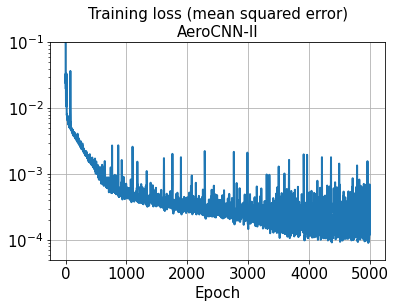

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

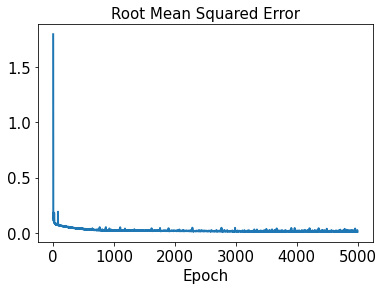

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

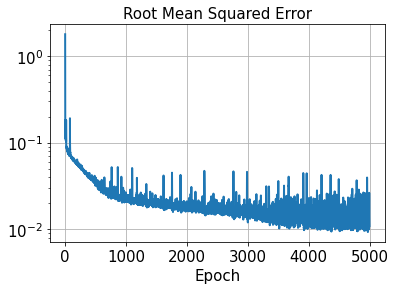

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [35]:
test_results = model.evaluate(x_train)

63/63 [==============================] - 0s 2ms/step - loss: 3.7797e-06 - rmse: 0.0000e+00


In [36]:
decoded_train = model.predict(x_train)

63/63 [==============================] - 0s 2ms/step


In [37]:
x_train.shape

(2016, 100, 100, 1)

In [38]:
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 5ms/step


In [39]:
error_train_abs = np.abs(decoded_train - y_train)

In [40]:
error_test_abs = np.abs(decoded_test - y_test)

In [41]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [42]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [43]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [44]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [45]:
decoded_train.shape

(2016, 2, 1)

In [46]:
os.chdir("D:\\TrainedModels\\20221005")
model.save('AeroCNN-II_50kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.019179884978982934


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.13926847327320055


In [49]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.017080221283077547


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.048642703448611435


In [51]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.13819049876331513


In [52]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.16530887034671754


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.018345241400250886, 0.008073166116709092, 0.017265468816695016, 0.026650930885301242, 0.031102899418914327, 0.018947726011093003, 0.014404669751679589, 0.007746797366726446, 0.012052166408045102, 0.01078179861176538, 0.017870317276930045, 0.018926020283016855, 0.024649753600119916, 0.0020294318214849074, 0.006501644481138911, 0.0011207967304246596, 0.020120059281265687, 0.004883856254596472, 0.016410166549454458, 0.011346009741877596, 0.055037521834679, 0.04390542122800022, 0.02864201033855497, 0.015025444474478058, 0.0015996530685944178, 0.027212811843835134, 0.09391629828733024, 0.01436843070721642, 0.026379794282993817, 0.12947937337035037, 0.061080625568092836, 0.07817738969005839, 0.021439610631956468, 0.016261823092928708, 0.023786342601452765, 0.030685965803967565, 0.11023470121597509, 0.016541384401812298, 0.016839781953711334, 0.023341488501010983, 0.003064479211281129, 0.011227405103868755, 0.005691189974120194, 0.009174803907022931, 0.013391896392385222, 0.012232833823748

In [54]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.02050838968021943, 0.05449264086752366, 0.0023666976394890295, 0.005694961434239665, 0.05507832745841338, 0.13078747034285773, 0.1103551262775626, 0.14883508493292252, 0.15541007130768317, 0.03249303719817454, 0.19049990936175273, 0.039513147023982335, 0.10526710111112826, 0.2653230699742392, 0.1133465220279334, 0.10725557548658969, 0.029393505978105448, 0.046986521975125164, 0.023958173283041045, 0.05844302079428879, 1.1642382362938632, 0.2098180074314721, 0.06941519331511557, 0.10573872433614723, 0.011561727438967823, 0.05884919248839341, 0.002078395828403649, 0.024555456557996586, 0.013184140487355262, 0.13281765354478506, 0.06725579490151917, 0.28496355821640623, 0.02144700193577873, 0.03486375859082047, 0.07748749899506806, 0.14881170734835916, 0.47490548651172093, 1.3698293760222615, 0.3490445323132802, 0.24212499956283523, 0.15431928438432013, 0.15320232058220273, 0.8993832144473661, 0.23531183305472594, 0.058944667745343245, 0.23271002481046404, 0.1081125960196235, 0.0526600

In [55]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.005513425958300876, 0.00812286817598976, 0.017204694533604126, 0.022926866572066894, 0.031160770575486673, 0.017972238472762504, 0.00847373482859298, 0.004219543539668214, 0.012008444008326439, 0.0004658478141288594, 0.0179218162879713, 0.016328392185673928, 0.016530238907796296, 0.001875311112883605, 0.005800100399949914, 0.0011562589529673102, 0.018053076930175046, 0.0006073996393575889, 0.015014690571138245, 0.01098039688831386, 0.04398630782755294, 0.007317981466509416, 0.028053325574046755, 0.010226688391297, 0.0013547189722460874, 0.010589261930658506, 0.09529457732623929, 0.01344889347563761, 0.0011279901206184564, 0.13378853404038404, 0.06416122811841692, 0.08194724424071044, 0.015582918367930344, 0.015647330871600282, 0.022693602951385682, 0.02843297323517192, 0.04531416487208727, 0.016582378003929452, 0.003434697423069251, 0.019192681475024228, 0.002852937797522346, 0.011117906099787885, 0.005226063171706789, 0.007595431380013708, 0.013239371974620367, 0.008032042671936546

In [56]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.07776236271066882, 0.006178117509617281, 0.025280649687501586, 0.3056438806868165, 0.0216138087627211, 0.03161436505578997, 0.22976354112264047, 0.20173955669117338, 0.03872490486729835, 0.24570274678765805, 0.012663894171490412, 0.0450967328461795, 0.0694034957744103, 0.0031372200011454267, 0.01047280728484885, 0.0007919914706788796, 0.045229720193352016, 0.11966401531724079, 0.19632903106991353, 0.06598328558407622, 0.3438227698986402, 0.20302712562899353, 0.1120229454855651, 0.3269683850583519, 0.02871951614683948, 0.5742601520976903, 0.049221858161365935, 0.02562173022889672, 0.09257388089514478, 0.07821967645153498, 0.020155950920484365, 0.05112972881195389, 0.06726902320086768, 0.03557294361767433, 0.1653931647945894, 0.19519590766514167, 0.35596826109357377, 0.008029916227460455, 0.44171891915693856, 0.5021777480951795, 0.04949804953638824, 0.07193095721531287, 0.0936839056090913, 0.16903929147726607, 0.015612096280781982, 0.032581632339794664, 0.01789594888771323, 0.04137823

In [57]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.35596826109357377

In [58]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.02101921891581192, 0.05385540444627956, 0.0007414901301887548, 0.0021470252584340687, 0.05078357666255731, 0.12958576471071823, 0.10906862923041542, 0.1485231608929557, 0.1555410911115549, 0.03144426170839244, 0.1897987373702518, 0.04024616436704984, 0.10458640783772688, 0.26225969781753034, 0.09998756387546574, 0.11418327972429795, 0.02922441759227648, 0.047003382367038216, 0.022127726789161677, 0.0585521071990206, 1.6683838704821576, 0.21003228581739733, 0.0689062921625812, 0.10575988040683691, 0.008003146194040823, 0.05875563397693312, 0.00097127768459815, 0.024011741608310558, 0.013088741135268605, 0.11823472404137547, 0.06389288302534052, 0.3049905021476137, 0.0002984529762427412, 0.03495931971641224, 0.07754114670553733, 0.14793632893593742, 0.47683328746130116, 1.3941854052259772, 0.3491606183732992, 0.24205312030259257, 0.15390471729899327, 0.15327410670287486, 0.9052736668339172, 0.23874659709250684, 0.0603008239409414, 0.23848345087229286, 0.10656725023287929, 0.0559498318

In [59]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.003883716163091516, 0.07354881687514217, 0.0300559936399636, 0.10019559970375123, 0.21586629492824141, 0.1591291442938203, 0.36025737397131835, 0.3145821332243517, 0.01798423136307132, 0.11856657028108936, 0.2113456370542193, 0.022475216555636862, 0.11361179110056101, 0.29320592369136167, 0.1915685280932539, 0.03892162000211267, 0.10038963118418938, 0.028490283145352523, 0.22149639525655557, 0.03090669305512261, 0.1693467324303935, 0.1714909376383918, 0.22491883162241796, 0.07461828446111722, 0.3424267415850638, 0.1503929912693259, 0.06948113936739563, 0.15474911076382733, 0.03275967758917299, 0.6218526205237674, 0.12245145853168363, 0.12797074855184468, 0.09370591558714698, 0.030766075530935254, 0.06372212173473299, 0.37601895806390223, 0.12054881867366402, 0.4870911059915134, 0.2981185667220442, 0.303032115777057, 0.40863971997943327, 0.11757481370585604, 0.005401943155101864, 0.15433477573882542, 0.03480393144026834, 0.15119266585862084, 0.12086025922330842, 0.015363189800517634,

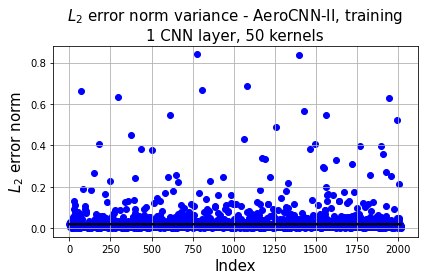

In [105]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

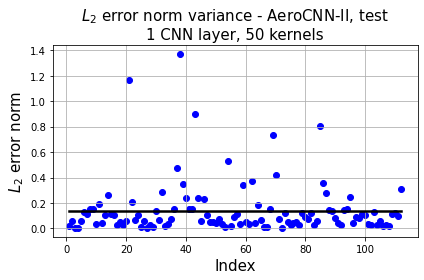

In [104]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

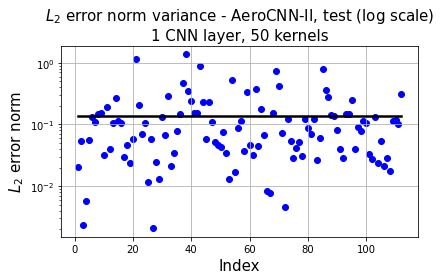

In [103]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

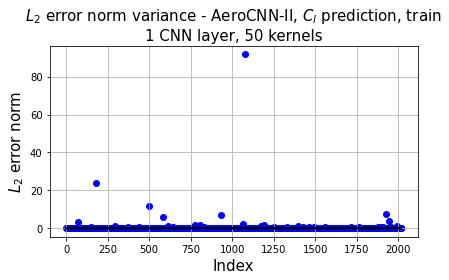

In [100]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

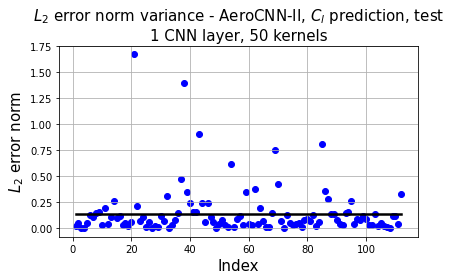

In [102]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

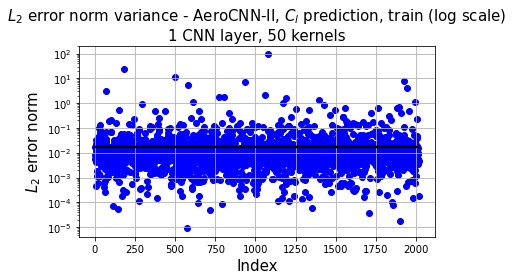

In [106]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

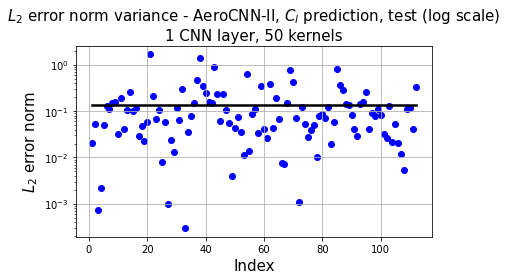

In [107]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

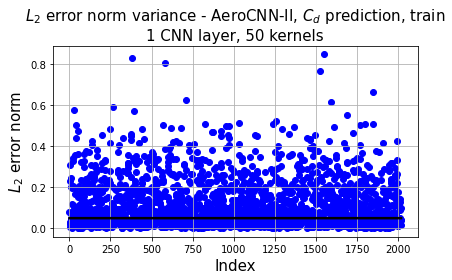

In [108]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

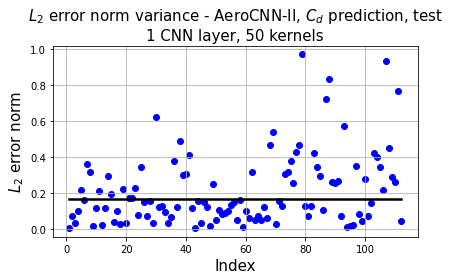

In [109]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

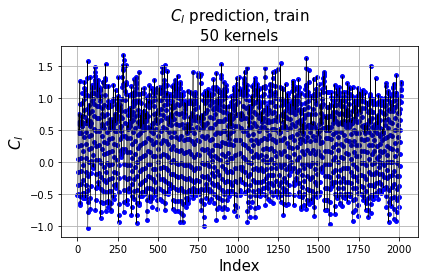

In [89]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

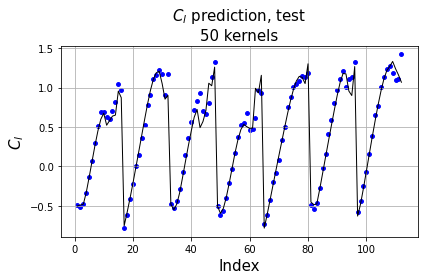

In [90]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

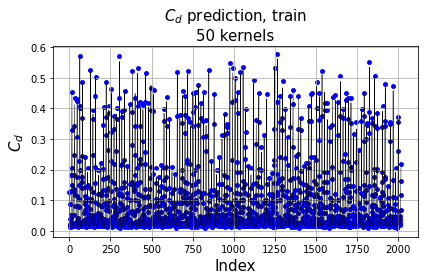

In [91]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

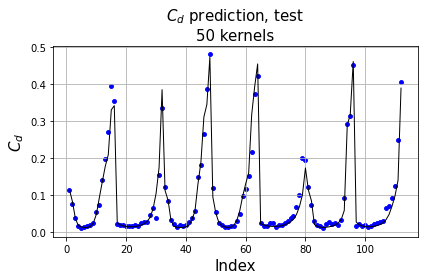

In [92]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

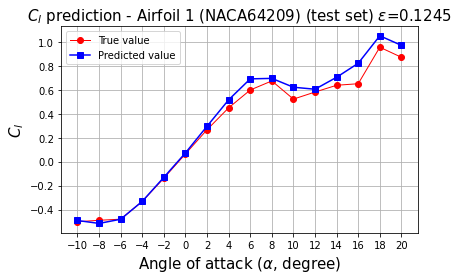

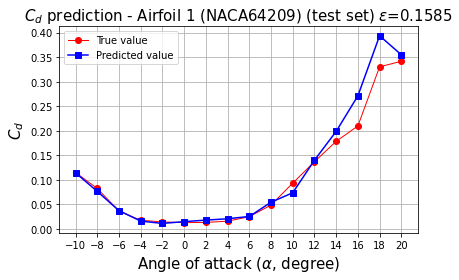

In [73]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

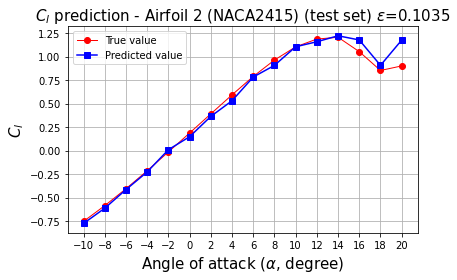

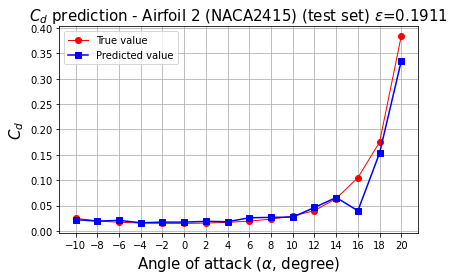

In [114]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [115]:
mseCl = np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2)/16
mseCd = np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2)/16
print(mseCl)
print(mseCd)

0.0066635123821404026
0.00045558066298121477


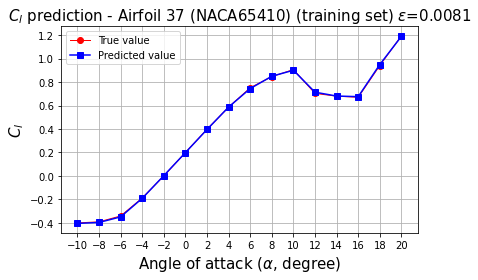

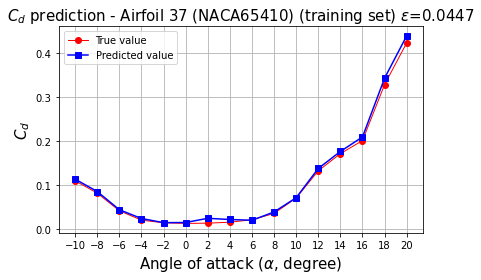

In [75]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

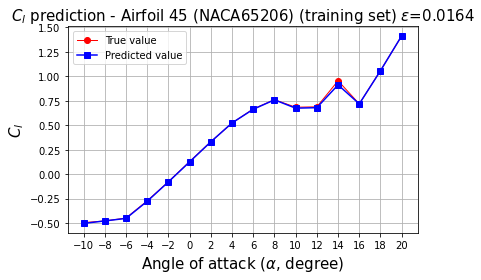

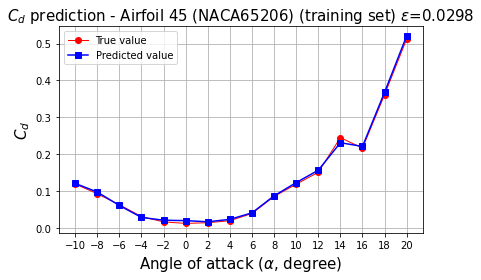

In [76]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

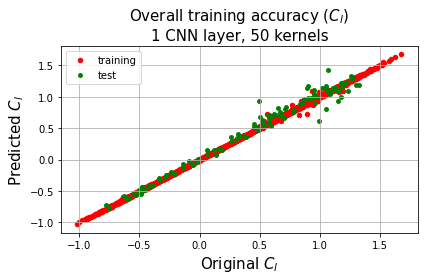

In [93]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 50 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

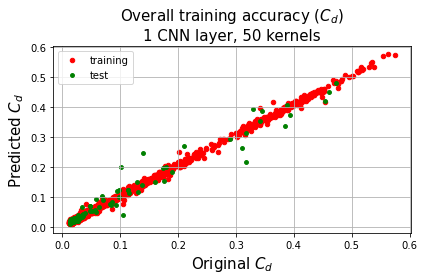

In [94]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

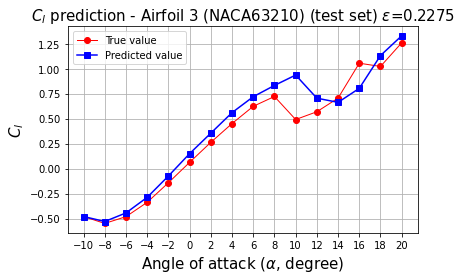

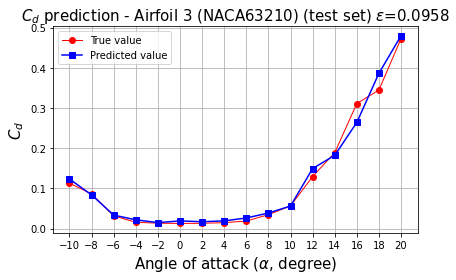

In [79]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

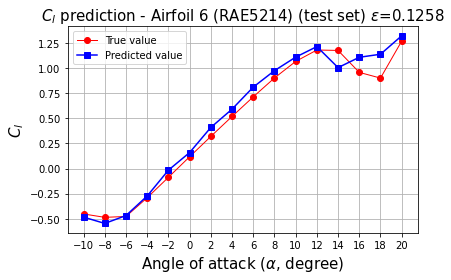

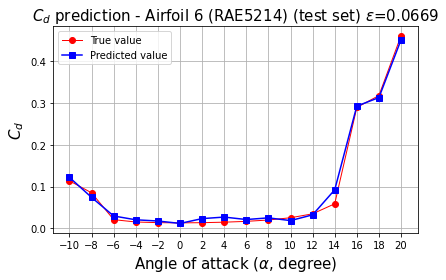

In [113]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [110]:
from sklearn.metrics import r2_score

r2TrainCl=r2_score(y_train[:,0,:], decoded_train[:,0,:])
r2TrainCd=r2_score(y_train[:,1,:], decoded_train[:,1,:])
r2TestCl=r2_score(y_test[:,0,:], decoded_test[:,0,:])
r2TestCd=r2_score(y_test[:,1,:], decoded_test[:,1,:])

print(r2TrainCl)

print(r2TrainCd)

print(r2TestCl)

print(r2TestCd)

0.9995964140349006
0.9963566453261807
0.9728415651534641
0.9575975461826953
